## Clip a Wflow model

Let's imagine you have built and calibrated a **Wflow** model for a whole country or continent. And now you have a new project for a small basin belonging to your big calibrated Wflow model. Instead of re-building the smaller model fomr scratch with HydroMT and re-doing the calibration steps, you can easily use the **clip** method of HydroMT to directly extract your smaller catchment out of your already existing big calibrated model!

This notebook demonstrates how to clip a **Wflow** model from an already existing one using the command line interace (CLI).

All lines in this notebook which start with `!` are executed from the command line. Within the notebook environment the logging messages are shown after completion. You can also copy these lines and paste these in your shell to get more direct feedback.

### HydroMT CLI clip interface

Using the **HydroMT clip** API we can extract a smaller wflow model out of an already existing bigger one. Let's get an overview of all the available options:

In [1]:
!hydromt clip --help

Usage: hydromt clip [OPTIONS] MODEL MODEL_ROOT MODEL_DESTINATION REGION

  Create a new model based on clipped region of an existing model.

  If the existing model contains forcing, they will also be clipped to the new
  model.

  Example usage: --------------

  Example usage to clip a wflow model for a subbasin derived from point
  coordinates snapped to cells with upstream area >= 50 km2 hydromt clip wflow
  /path/to/model_root /path/to/model_destination "{'subbasin': [-7.24, 62.09],
  'wflow_uparea': 50}"

  Example usage basin based on ID from model_root basins map hydromt clip
  wflow /path/to/model_root /path/to/model_destination "{'basin': 1}"

  Example usage basins whose outlets are inside a geometry hydromt clip wflow
  /path/to/model_root /path/to/model_destination "{'outlet':
  'geometry.geojson'}"

  All available option in the clip_grid function help.

Options:
  -q, --quiet    Decrease verbosity.
  -v, --verbose  Increase verbosity.
  --help         Show this message a

### Clip a small sub-basin

In [2]:
# NOTE: copy this line (without !) to your shell for more direct feedback
!hydromt clip wflow "wflow_piave_subbasin" "./wflow_test_clip" "{'subbasin': [12.3006, 46.4324], 'wflow_streamorder': 4}" -v

2025-04-09 16:15:03,181 - clip - log - INFO - HydroMT version: 0.10.1
2025-04-09 16:15:03,181 - clip - main - INFO - Clipping instance of wflow model.
2025-04-09 16:15:03,181 - clip - main - INFO - Region: {'subbasin': [12.3006, 46.4324], 'wflow_streamorder': 4}
2025-04-09 16:15:03,601 - clip - model_api - INFO - Initializing wflow model from hydromt_wflow (v0.8.0).
2025-04-09 16:15:03,601 - clip - data_catalog - INFO - Parsing data catalog from C:\code\py_dev\hydromt_wflow\hydromt_wflow\data\parameters_data.yml
2025-04-09 16:15:03,621 - clip - main - INFO - Reading model to clip
2025-04-09 16:15:03,626 - clip - wflow - INFO - Read grid from C:\code\py_dev\hydromt_wflow\docs\_examples\wflow_piave_subbasin\staticmaps.nc
2025-04-09 16:15:03,994 - clip - wflow - INFO - Reading model staticgeom files.
2025-04-09 16:15:04,061 - clip - wflow - INFO - Read forcing from C:\code\py_dev\hydromt_wflow\docs\_examples\wflow_piave_subbasin\inmaps.nc
2025-04-09 16:15:04,086 - clip - wflow - INFO - Re

The example above means the following: run **hydromt clip** with:

* `wflow` : i.e. clip a wflow model
* `wflow_piave_subbasin`: original model to clip
* `./wflow_test_clip` : output model folder
* `"{'subbasin': [12.3006, 46.4324], 'wflow_streamorder': 4}"` : derive a subbasin with its outlet at the given x,y coordinates (WGS84) snapped to a river with minimum stream order (wflow_streamorder) of 4. All *REGION* options are described in the [docs](https://deltares.github.io/hydromt/latest/user_guide/model_region)
* `-vv` : give some extra verbosity (2 * v) to display feedback on screen. Now debug messages are provided.

NOTE: Compared to build, you may notice here that the streamorder argument is called 'wflow_streamorder'. As we are clipping a wflow model, the name here should correspond to the name of the stream order map inside of your wflow model.

Compared to build, the clip command line has less options (no configuration file and no data catalog or resolution). Clip simply re-uses the original model data and extract all the informations from the model for our clipped region location.

### Visualize and/or inspect model schematization

The **wflow plot** example notebook contains scripts to visualize your model.

Here we will just simply plot the region of the different model (original and clipped) to check the differences between them.

In [3]:
# Import plot packages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

# import descartes  # used under the hood to plot polygons

In [4]:
import numpy as np
import hydromt
from hydromt_wflow import WflowModel

In [5]:
# Load both models with hydromt
mod0 = WflowModel(root="wflow_piave_subbasin", mode="r")
mod1 = WflowModel(root="wflow_test_clip", mode="r")

In [6]:
# read/derive river geometries
gdf_riv0 = mod0.rivers
gdf_riv1 = mod1.rivers
# read/derive model basin boundary
gdf_bas0 = mod0.basins
gdf_bas1 = mod1.basins

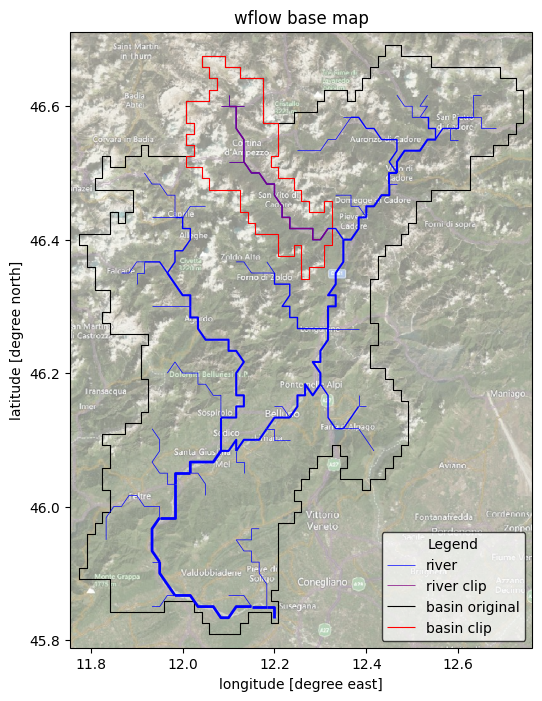

In [7]:
# we assume the model maps are in the geographic CRS EPSG:4326
proj = ccrs.PlateCarree()
# adjust zoomlevel and figure size to your basis size & aspect
zoom_level = 10
figsize = (10, 8)
shaded = False


# initialize image with geoaxes
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection=proj)
extent = np.array(mod0.grid.raster.box.buffer(0.02).total_bounds)[[0, 2, 1, 3]]
ax.set_extent(extent, crs=proj)

# add sat background image
ax.add_image(cimgt.QuadtreeTiles(), zoom_level, alpha=0.5)

# plot rivers with increasing width with stream order
gdf_riv0.plot(ax=ax, lw=gdf_riv0["strord"] / 2, color="blue", zorder=3, label="river")
gdf_riv1.plot(
    ax=ax, lw=gdf_riv1["strord"] / 2, color="purple", zorder=3, label="river clip"
)
# plot the basin boundary
gdf_bas0.boundary.plot(ax=ax, color="k", linewidth=0.8, label="basin original")
gdf_bas1.boundary.plot(ax=ax, color="r", linewidth=0.8, label="basin clip")

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_ylabel(f"latitude [degree north]")
ax.set_xlabel(f"longitude [degree east]")
_ = ax.set_title(f"wflow base map")
legend = ax.legend(
    handles=[*ax.get_legend_handles_labels()[0]],
    title="Legend",
    loc="lower right",
    frameon=True,
    framealpha=0.7,
    edgecolor="k",
    facecolor="white",
)